In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import csv
import shapely
import shapely.wkt
from shapely.geometry import Point, Polygon
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import descartes
import numpy as np
import geopy
from datetime import datetime
import os, csv, shapely, shapely.wkt, descartes, geopy, pickle, cloudpickle

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)
pd.options.display.float_format = '{:.4f}'.format
import seaborn as sns
import matplotlib.pyplot as plt
import descartes
import plotly.express as px
import plotly.graph_objects as go
from sklearn.model_selection import cross_val_score

from sklearn import metrics
from sklearn import metrics as skm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from fairlearn.metrics import equalized_odds_ratio, MetricFrame, demographic_parity_difference, demographic_parity_ratio, selection_rate, equalized_odds_difference, true_positive_rate, false_positive_rate
from fairlearn.reductions import BoundedGroupLoss, ZeroOneLoss, ExponentiatedGradient, SquareLoss, AbsoluteLoss, GridSearch, DemographicParity, ErrorRate, EqualizedOdds
from sklearn.model_selection import KFold

# pd.set_option('display.max_rows', 10)
# sns.set()
# sns.color_palette("ch:s=.25,rot=-.25")
np.set_printoptions(suppress=True)


Bad key "text.kerning_factor" on line 4 in
/Users/yhannnn/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
CITY = "C_"
save_dir = CITY + 'clas_res/'
save_dir_preprocess = os.path.join(save_dir, CITY + 'preprocess_fig/')
save_dir_models = os.path.join(save_dir, CITY + 'model_res/') 
save_dir_forecast = os.path.join(save_dir, CITY + 'forecast/')
save_dir_fairst = os.path.join(save_dir, CITY + 'fairst/')

if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
if not os.path.exists(save_dir_preprocess):
    os.makedirs(save_dir_preprocess)

if not os.path.exists(save_dir_models):
    os.makedirs(save_dir_models)
    
if not os.path.exists(save_dir_forecast):
    os.makedirs(save_dir_forecast)
    
if not os.path.exists(save_dir_fairst):
    os.makedirs(save_dir_fairst)

In [3]:
df_census_tract = pd.read_csv("data_created/cells_census_tract.csv", index_col = 0)
df_public_transit_means = pd.read_csv("data_created/census_data/public_transit_means.csv", index_col = 0)
df_employment_rate = pd.read_csv("data_created/census_data/employment_rate.csv", index_col = 0)
df_2019_census_tract_hamilton = pd.read_csv("data_created/census_data/2019_census_tract_hamilton.csv", index_col = 0)

df_geo = df_census_tract[["cell_num", "geometry", "centroid", "tract_id", "stations"]]
df_census_tract = df_census_tract[["cell_num", "tract_id", "geometry", "stations", "capacity"]]

df_census_tract2 = df_2019_census_tract_hamilton.merge(df_public_transit_means, how = 'left', on = 'tract_id')
df_census_tract2 = df_census_tract2.merge(df_employment_rate, how = 'left', on = 'tract_id')

df_census_tract_final = df_census_tract.merge(df_census_tract2, how = 'left', on = 'tract_id')

df_census_tract_final.drop(columns = ["geometry"], inplace = True)
df_census_tract_final

,cell_num,tract_id,stations,capacity,total_population,total_housing_units,median_income,white_pct,black_pct,hispanic_pct,mean_travel_time_to_work,num_works_over_16,pct_total_car_truck_van,pct_car_truck_van_alone,pct_car_truck_van_carpooled,pct_public_transit,pct_walked,pct_bicycle,pct_other_means,pct_wfh,population_over_16,population_over_16_employed,population_over_16_unemployed
0,104,47065012100,0,0,6556,2922,59507.0000,86.7907,8.2215,1.0830,19.5814,2765.0000,94.3000,88.3000,6.0000,0.0000,0.7000,0.0000,0.0000,5.1000,2851,2780,71
1,105,47065012100,0,0,6556,2922,59507.0000,86.7907,8.2215,1.0830,19.5814,2765.0000,94.3000,88.3000,6.0000,0.0000,0.7000,0.0000,0.0000,5.1000,2851,2780,71
2,156,47065012100,0,0,6556,2922,59507.0000,86.7907,8.2215,1.0830,19.5814,2765.0000,94.3000,88.3000,6.0000,0.0000,0.7000,0.0000,0.0000,5.1000,2851,2780,71
3,157,47065012100,0,0,6556,2922,59507.0000,86.7907,8.2215,1.0830,19.5814,2765.0000,94.3000,88.3000,6.0000,0.0000,0.7000,0.0000,0.0000,5.1000,2851,2780,71
4,158,47065012100,0,0,6556,2922,59507.0000,86.7907,8.2215,1.0830,19.5814,2765.0000,94.3000,88.3000,6.0000,0.0000,0.7000,0.0000,0.0000,5.1000,2851,2780,71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1825,4651,47065011201,0,0,12235,4993,91029.0000,81.0217,8.6228,8.2223,27.6645,5216.0000,88.6000,80.4000,8.2000,0.0000,2.0000,0.0000,0.0000,9.4000,5529,5315,214
1826,4652,47065011201,0,0,12235,4993,91029.0000,81.0217,8.6228,8.2223,27.6645,5216.0000,88.6000,80.4000,8.2000,0.0000,2.0000,0.0000,0.0000,9.4000,5529,5315,214
1827,4704,47065011201,0,0,12235,4993,91029.0000,81.0217,8.6228,8.2223,27.6645,5216.0000,88.6000,80.4000,8.2000,0.0000,2.0000,0.0000,0.0000,9.4000,5529,5315,214
1828,4705,47065011201,0,0,12235,4993,91029.0000,81.0217,8.6228,8.2223,27.6645,5216.0000,88.6000,80.4000,8.2000,0.0000,2.0000,0.0000,0.0000,9.4000,5529,5315,214


Text(0.5, 1, 'Distribution of number of stations in Chattanooga')

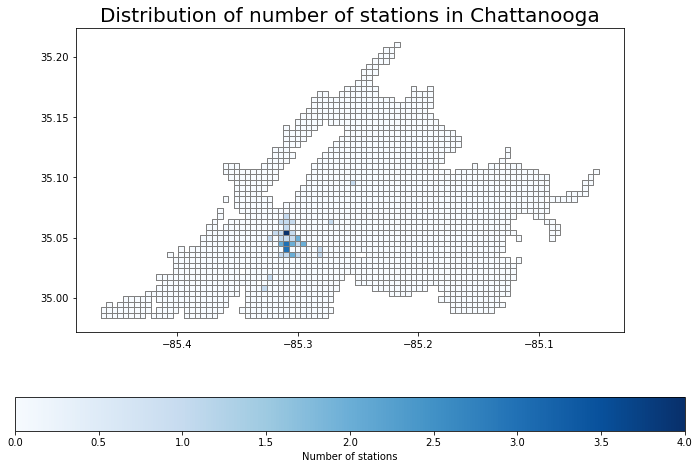

In [4]:
for row,col in df_geo.iterrows():
    df_geo.at[row, 'geometry'] = shapely.wkt.loads(df_geo.loc[row]['geometry'])
    df_geo.at[row, 'centroid'] = shapely.wkt.loads(df_geo.loc[row]['centroid'])
    
df_geo = gpd.GeoDataFrame(df_geo, crs='EPSG:2956', geometry='geometry')
# type(pgh_grid_income.loc[0]['geometry'])

df_geo.to_csv(os.path.join(save_dir_forecast, CITY + "df_geo.csv"))

df_geo.plot(column="stations", cmap='Blues',edgecolor = "grey", figsize=(12, 8),  
                    legend = True, legend_kwds={'label': "Number of stations",'orientation': "horizontal",})
plt.title("Distribution of number of stations in Chattanooga", fontsize=20)
# plt.savefig(os.path.join(save_dir_preprocess, CITY+"stations_dist"), facecolor = 'w')

In [5]:
df_walk_score = pd.read_csv("data_created/walk_score2.csv", index_col = 0).drop(columns = ['centroid', "walk_score_description", 
                                                                            "bike_description", "transit_description"])
df_walk_score.head()

,cell_num,walk_score,bike_score,transit_score,transit_summary
0,104,0.0000,-1.0000,-1.0000,NaN
1,105,0.0000,-1.0000,-1.0000,NaN
2,156,0.0000,-1.0000,-1.0000,NaN
3,157,0.0000,-1.0000,-1.0000,NaN
4,158,0.0000,-1.0000,-1.0000,NaN


In [6]:
# extract parts from "nearby"

df_walk_score['nearby_bus'] = 0
df_walk_score['nearby_rail'] = 0
df_walk_score['nearby_other'] = 0
df_walk_score['nearby_routes'] = 0

for row,col in df_walk_score.iterrows():
    # if nearby == NaN
    if type(df_walk_score.loc[row]['transit_summary']) == float:
        df_walk_score.at[row, 'nearby_bus'] = 0
        df_walk_score.at[row, 'nearby_rail'] = 0
        df_walk_score.at[row, 'nearby_other'] = 0
        
    else:
        routes = df_walk_score.loc[row]['transit_summary']
        routes = routes.split(' ')
        nearby_routes = routes[0]
        nearby_bus = routes[3]
        nearby_rail = routes[5]
        nearby_other = routes[7]

        df_walk_score.at[row, 'nearby_bus'] = nearby_bus
        df_walk_score.at[row, 'nearby_rail'] = nearby_rail
        df_walk_score.at[row, 'nearby_other'] = nearby_other
        df_walk_score.at[row, 'nearby_routes'] = nearby_routes
        
df_walk_score.drop(columns = ["transit_summary"], inplace = True)
df_walk_score.reset_index(drop = True, inplace = True)

In [7]:
df_all = df_census_tract_final.merge(df_walk_score, on = 'cell_num')

# match fairST, replace negative value with 0
df_all[df_all < 0] = 0
df_all.to_csv(os.path.join(save_dir_forecast, CITY + "df_all.csv"))
df_all.head()

,cell_num,tract_id,stations,capacity,total_population,total_housing_units,median_income,white_pct,black_pct,hispanic_pct,mean_travel_time_to_work,num_works_over_16,pct_total_car_truck_van,pct_car_truck_van_alone,pct_car_truck_van_carpooled,pct_public_transit,pct_walked,pct_bicycle,pct_other_means,pct_wfh,population_over_16,population_over_16_employed,population_over_16_unemployed,walk_score,bike_score,transit_score,nearby_bus,nearby_rail,nearby_other,nearby_routes
0,104,47065012100,0,0,6556,2922,59507.0000,86.7907,8.2215,1.0830,19.5814,2765.0000,94.3000,88.3000,6.0000,0.0000,0.7000,0.0000,0.0000,5.1000,2851,2780,71,0.0000,0.0000,0.0000,0,0,0,0
1,105,47065012100,0,0,6556,2922,59507.0000,86.7907,8.2215,1.0830,19.5814,2765.0000,94.3000,88.3000,6.0000,0.0000,0.7000,0.0000,0.0000,5.1000,2851,2780,71,0.0000,0.0000,0.0000,0,0,0,0
2,156,47065012100,0,0,6556,2922,59507.0000,86.7907,8.2215,1.0830,19.5814,2765.0000,94.3000,88.3000,6.0000,0.0000,0.7000,0.0000,0.0000,5.1000,2851,2780,71,0.0000,0.0000,0.0000,0,0,0,0
3,157,47065012100,0,0,6556,2922,59507.0000,86.7907,8.2215,1.0830,19.5814,2765.0000,94.3000,88.3000,6.0000,0.0000,0.7000,0.0000,0.0000,5.1000,2851,2780,71,0.0000,0.0000,0.0000,0,0,0,0
4,158,47065012100,0,0,6556,2922,59507.0000,86.7907,8.2215,1.0830,19.5814,2765.0000,94.3000,88.3000,6.0000,0.0000,0.7000,0.0000,0.0000,5.1000,2851,2780,71,0.0000,0.0000,0.0000,0,0,0,0


In [8]:
# load outflow dataset
df_outflow_all = pd.read_csv("data_created/cell_outflow.csv", index_col = 0)
df_outflow = df_outflow_all[df_outflow_all.year.isin([2015, 2016, 2017, 2018, 2019])]
outflow_complete = df_outflow
# df_outflow.to_csv("df_outflow.csv")

In [9]:
# merge outflow
df = outflow_complete.merge(df_all, on = 'cell_num', how = 'left')
# df = outflow_complete.merge(df_all, on = 'cell_num', how = 'left')
df

,cell_num,year,month,outflow,tract_id,stations,capacity,total_population,total_housing_units,median_income,white_pct,black_pct,hispanic_pct,mean_travel_time_to_work,num_works_over_16,pct_total_car_truck_van,pct_car_truck_van_alone,pct_car_truck_van_carpooled,pct_public_transit,pct_walked,pct_bicycle,pct_other_means,pct_wfh,population_over_16,population_over_16_employed,population_over_16_unemployed,walk_score,bike_score,transit_score,nearby_bus,nearby_rail,nearby_other,nearby_routes
0,1617,2018,7,145,47065001800,1,19,2546,1383,53115.0000,69.5994,14.7290,6.3236,20.1950,1342.0000,94.2000,87.6000,6.6000,0.1000,0.2000,0.7000,0.2000,4.5000,1385,1349,36,54.0000,45.0000,25.0000,1,0,0,1
1,1617,2018,8,117,47065001800,1,19,2546,1383,53115.0000,69.5994,14.7290,6.3236,20.1950,1342.0000,94.2000,87.6000,6.6000,0.1000,0.2000,0.7000,0.2000,4.5000,1385,1349,36,54.0000,45.0000,25.0000,1,0,0,1
2,1617,2018,9,126,47065001800,1,19,2546,1383,53115.0000,69.5994,14.7290,6.3236,20.1950,1342.0000,94.2000,87.6000,6.6000,0.1000,0.2000,0.7000,0.2000,4.5000,1385,1349,36,54.0000,45.0000,25.0000,1,0,0,1
3,1617,2018,10,111,47065001800,1,19,2546,1383,53115.0000,69.5994,14.7290,6.3236,20.1950,1342.0000,94.2000,87.6000,6.6000,0.1000,0.2000,0.7000,0.2000,4.5000,1385,1349,36,54.0000,45.0000,25.0000,1,0,0,1
4,1617,2018,11,87,47065001800,1,19,2546,1383,53115.0000,69.5994,14.7290,6.3236,20.1950,1342.0000,94.2000,87.6000,6.6000,0.1000,0.2000,0.7000,0.2000,4.5000,1385,1349,36,54.0000,45.0000,25.0000,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1446,2468,2019,8,526,47065011411,1,25,4262,1985,45459.0000,56.8278,40.9432,0.0000,23.7458,2042.0000,97.1000,87.3000,9.8000,0.0000,0.1000,0.9000,0.0000,1.9000,2199,2072,127,10.0000,70.0000,0.0000,0,0,0,0
1447,2468,2019,9,450,47065011411,1,25,4262,1985,45459.0000,56.8278,40.9432,0.0000,23.7458,2042.0000,97.1000,87.3000,9.8000,0.0000,0.1000,0.9000,0.0000,1.9000,2199,2072,127,10.0000,70.0000,0.0000,0,0,0,0
1448,2468,2019,10,397,47065011411,1,25,4262,1985,45459.0000,56.8278,40.9432,0.0000,23.7458,2042.0000,97.1000,87.3000,9.8000,0.0000,0.1000,0.9000,0.0000,1.9000,2199,2072,127,10.0000,70.0000,0.0000,0,0,0,0
1449,2468,2019,11,120,47065011411,1,25,4262,1985,45459.0000,56.8278,40.9432,0.0000,23.7458,2042.0000,97.1000,87.3000,9.8000,0.0000,0.1000,0.9000,0.0000,1.9000,2199,2072,127,10.0000,70.0000,0.0000,0,0,0,0


In [10]:
# weather dataset
df_weather = pd.read_csv("data_created/chattanooga_weather.csv")
# get year and month
for index, row in df_weather.iterrows():
    data = [row.Date.astype(int)]
    df_weather.loc[index, "year"] = [datetime.strptime(str(s), '%Y%m') for s in data][0].year
    df_weather.loc[index, "month"] = [datetime.strptime(str(s), '%Y%m') for s in data][0].month
    
df_weather.drop(columns = ["Date"], inplace=True)
df_weather.rename(columns = {"Value": "weather", }, inplace=True)
# df_weather.to_csv(os.path.join(save_dir_forecast, CITY + "df_weather.csv"))

In [11]:
# merge with dataset
df = df.merge(df_weather, on = ["year", "month"])
df.head()

,cell_num,year,month,outflow,tract_id,stations,capacity,total_population,total_housing_units,median_income,white_pct,black_pct,hispanic_pct,mean_travel_time_to_work,num_works_over_16,pct_total_car_truck_van,pct_car_truck_van_alone,pct_car_truck_van_carpooled,pct_public_transit,pct_walked,pct_bicycle,pct_other_means,pct_wfh,population_over_16,population_over_16_employed,population_over_16_unemployed,walk_score,bike_score,transit_score,nearby_bus,nearby_rail,nearby_other,nearby_routes,weather
0,1617,2018,7,145,47065001800,1,19,2546,1383,53115.0000,69.5994,14.7290,6.3236,20.1950,1342.0000,94.2000,87.6000,6.6000,0.1000,0.2000,0.7000,0.2000,4.5000,1385,1349,36,54.0000,45.0000,25.0000,1,0,0,1,81.2000
1,1671,2018,7,265,47065001900,1,19,3730,1983,23661.0000,10.8043,87.8284,0.0000,21.4104,1142.0000,88.2000,83.7000,4.5000,9.6000,0.4000,0.0000,1.8000,0.0000,1543,1170,373,48.0000,58.0000,25.0000,1,0,0,1,81.2000
2,1678,2018,7,190,47065001600,1,19,2632,1989,12906.0000,13.9438,78.0015,2.7736,30.2027,559.0000,61.7000,44.2000,17.5000,22.2000,16.1000,0.0000,0.0000,0.0000,730,542,188,34.0000,48.0000,36.0000,10,0,0,10,81.2000
3,1731,2018,7,252,47065001600,1,15,2632,1989,12906.0000,13.9438,78.0015,2.7736,30.2027,559.0000,61.7000,44.2000,17.5000,22.2000,16.1000,0.0000,0.0000,0.0000,730,542,188,37.0000,44.0000,43.0000,10,0,0,10,81.2000
4,1779,2018,7,146,47065002000,1,15,1484,854,64352.0000,64.2857,28.5040,3.8410,18.0113,764.0000,69.1000,64.5000,4.6000,9.2000,14.0000,3.1000,0.0000,4.6000,810,789,21,70.0000,89.0000,42.0000,8,0,0,8,81.2000


In [12]:
# select feature
df.drop(columns = ['white_pct', 'black_pct', 'hispanic_pct', 'population_over_16', 
                   'pct_total_car_truck_van', "pct_bicycle", "tract_id"], inplace = True)

In [13]:
# calculate normalized pop: for RFG
cell_num_ls = df[df.year == 2019].cell_num.unique()
normalized_pop_df = pd.DataFrame(0, columns = ['pop'] , index = cell_num_ls)
        
for cell in cell_num_ls:
    pop = df[df.year == 2019][df[df.year == 2019].cell_num == cell]['total_population'].reset_index(drop=True)[0]
    normalized_pop_df.loc[cell, 'pop'] = pop
    
normalized_pop_df["normalized_pop"] = normalized_pop_df["pop"] / normalized_pop_df["pop"].sum()
# normalized_pop_df.to_csv(os.path.join(save_dir_fairst, "normalized_pop_df.csv"))

## 2. Fairness

In [14]:
print(df["median_income"].describe())
# training set
df["income_group"] = 0
for row, col in df.iterrows():
    if df.loc[row]["median_income"] > 50000:
        df.at[row, "income_group"] = 1
        
df[["cell_num", "income_group"]].to_csv(os.path.join(save_dir_fairst, "df_income.csv"))
df.drop(columns = ["median_income"], inplace = True)

count    1451.0000
mean    47455.8766
std     19115.8437
min     12906.0000
25%     31204.0000
50%     49375.0000
75%     63699.0000
max     80400.0000
Name: median_income, dtype: float64


Text(0, 0.5, 'Count')

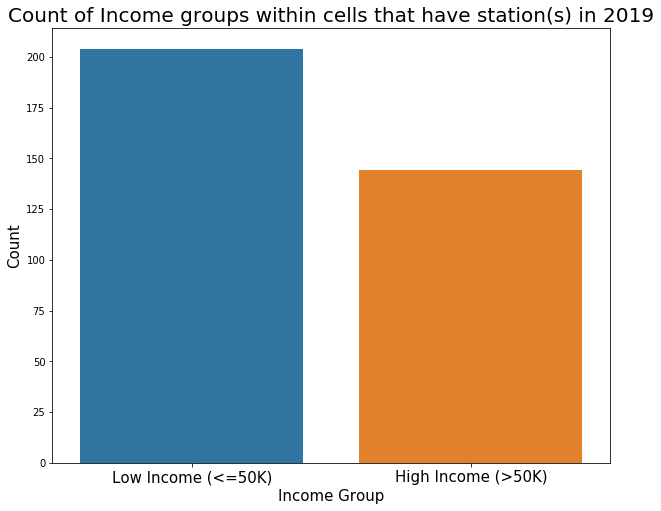

In [15]:
fig, ax = plt.subplots(figsize = (10, 8))
sns.countplot(df[df.year == 2019]["income_group"])
plt.title("Count of Income groups within cells that have station(s) in 2019", fontsize = 20)
plt.xticks([0, 1], ["Low Income (<=50K)", "High Income (>50K)"], fontsize = 15)
plt.xlabel("Income Group", fontsize = 15)
plt.ylabel("Count", fontsize = 15)
# plt.savefig(os.path.join(save_dir_preprocess, CITY+"income_group_2019"))

### 2.2 outflow class

In [16]:
df["outflow_class"] = 0
for row, col in df.iterrows():
        
    if df.loc[row]["outflow"] > df.outflow.mean():
        df.at[row, "outflow_class"] = 1
        
df.drop(columns = ["outflow"], inplace = True)

Text(0.5, 1.0, 'Distrbution of outflow classes with income classess in 2019')

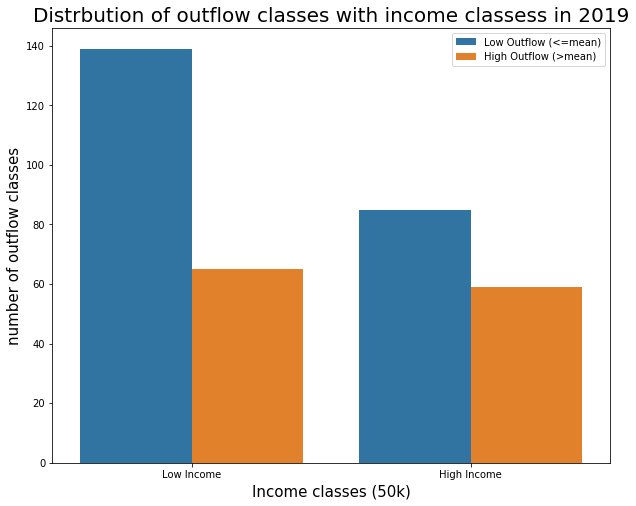

In [17]:
# sns.set(rc={'figure.figsize':(8, 6)})
fig, ax = plt.subplots(figsize = (10, 8))
ax = sns.countplot(df[df.year == 2019]['income_group'], hue = df[df.year == 2019]["outflow_class"])
# ax.set_title('Count of outflow classes for two income groups')
ax.set_ylabel('number of outflow classes', fontsize = 15)
ax.set_xlabel("Income classes (50k)", fontsize = 15)
plt.legend(["Low Outflow (<=mean)", "High Outflow (>mean)"])

# # plt.savefig("fig1")
plt.xticks([0, 1], ['Low Income', 'High Income'])
plt.title("Distrbution of outflow classes with income classess in 2019", fontsize = 20)
# plt.savefig(os.path.join(save_dir_preprocess, CITY+"outflow_income_group_2019"))

In [18]:
df_low_income = df[df.year == 2019][df[df.year == 2019]["income_group"] == 0]
df_high_income = df[df.year == 2019][df[df.year == 2019]["income_group"] == 1]

low_income_low_outflow = len(df_low_income[df_low_income["outflow_class"] == 0])/len(df_low_income)
low_income_high_outflow = len(df_low_income[df_low_income["outflow_class"] == 1])/len(df_low_income)

high_income_low_outflow = len(df_high_income[df_high_income["outflow_class"] == 0])/len(df_high_income)
high_income_high_outflow = len(df_high_income[df_high_income["outflow_class"] == 1])/len(df_high_income)

fig2_df = pd.DataFrame({"Outflow": [low_income_high_outflow*100, high_income_high_outflow*100],
                       "Income": ["Low", "High"]})
fig2_df

,Outflow,Income
0,31.8627,Low
1,40.9722,High


Text(0.5, 1.0, 'Percentage of high outflow classes in 2019')

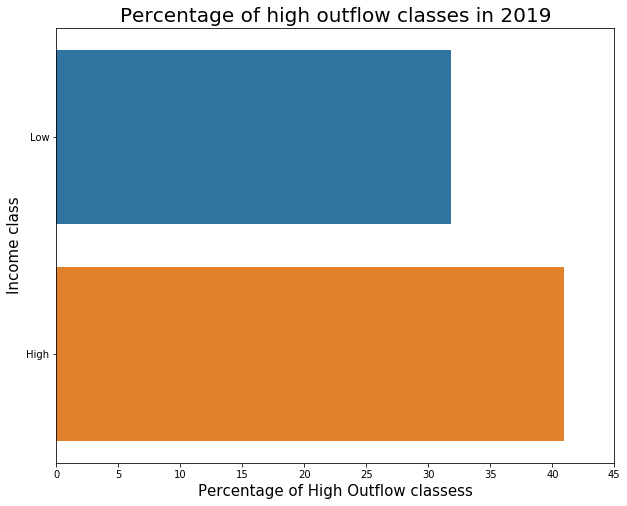

In [19]:
# sns.set(rc={'figure.figsize':(8, 6)})
fig, ax = plt.subplots(figsize = (10, 8))
ax = sns.barplot(data = fig2_df, x = 'Outflow', y = 'Income')

ax.set_ylabel('Income class', fontsize = 15)
ax.set_xlabel("Percentage of High Outflow classess", fontsize = 15)
ax.set_xlim(0, 45)
plt.title("Percentage of high outflow classes in 2019", fontsize = 20)
# plt.savefig("Figures/Fig2b.svg")

In [20]:
# Train Test split
df_1518 = df[df["year"].isin([2015, 2016, 2017, 2018])] # 1032
df_19 = df[df["year"].isin([2019])]

df_1518 = df_1518.drop(columns = ["year"])
df_19 = df_19.drop(columns = ["year"])

In [21]:
X_train = df_1518.drop(columns = ["outflow_class", "cell_num"])
X_test = df_19.drop(columns = ["outflow_class", "cell_num"])

y_train = df_1518["outflow_class"]
y_test = df_19["outflow_class"]

A_train = df_1518["income_group"]
A_test = df_19["income_group"]

y_test_cell_num = df_19[["cell_num", "income_group"]]
y_test_cell_num

,cell_num,income_group
168,1617,1
169,1671,0
170,1678,0
171,1731,0
172,1779,1
...,...,...
511,1989,0
512,2143,0
513,2144,0
514,2253,0


In [22]:
# reset index
X_train.reset_index(drop = True, inplace = True)
X_test.reset_index(drop = True, inplace = True)
y_train.reset_index(drop = True, inplace = True)
y_test.reset_index(drop = True, inplace = True)
A_train.reset_index(drop = True, inplace = True)
A_test.reset_index(drop = True, inplace = True)

X_train.to_csv(os.path.join(save_dir_forecast, CITY + "X_train.csv"))

### 3 Fairness models

In [23]:
# summary df
model_summary = pd.DataFrame(0, columns = ["accuracy", "accuracy_diff", "selection_rate", "selection_rate_diff"], 
                             index = ["random_forest", "exp_grad", "grid_search"])

# model_summary.to_csv(os.path.join(save_dir_models, "model_summary.csv"))

In [24]:
rf_best = pickle.load(open(os.path.join(save_dir_models, CITY + "random_forest.pkl"), 'rb'))

accuracy         0.8736
selection_rate   0.2414
dtype: object
------------------------------
             accuracy selection_rate
income_group                        
0              0.8333         0.1618
1              0.9306         0.3542
------------------------------
accuracy: 0.87356
accuracy diff: 0.09722
selection_rate: 0.24138
selection_rate diff: 0.19240
------------------------------


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7958b4b410>,
      dtype=object)

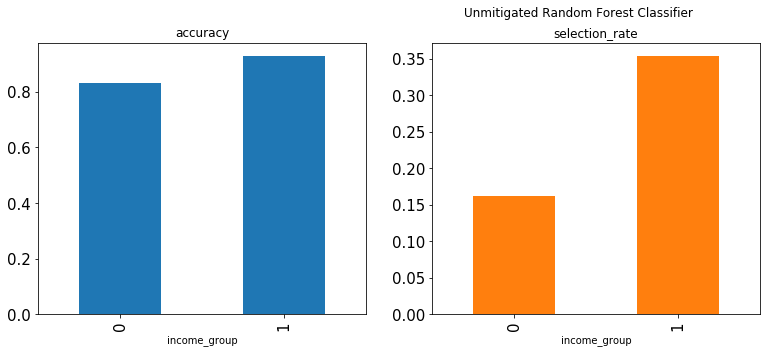

In [25]:
'''
TEST SET
'''
# rf_best = grid_search.best_estimator_
rf_best.fit(X_train, y_train)
y_pred_rf_gs = rf_best.predict(X_test)

# Metric evaluation
metric_frame_rf_gs = MetricFrame(metric = 
                                    {"accuracy": skm.accuracy_score,
                                     "selection_rate": selection_rate},
                                   sensitive_features = A_test,
                                   y_true = y_test,
                                   y_pred = y_pred_rf_gs)

print(metric_frame_rf_gs.overall)
print("-"*30)
print(metric_frame_rf_gs.by_group)
print("-"*30)
print("accuracy:", "{:.5f}".format(metric_frame_rf_gs.overall["accuracy"]))
print("accuracy diff:", "{:.5f}".format(metric_frame_rf_gs.difference()["accuracy"]))
print("selection_rate:", "{:.5f}".format(metric_frame_rf_gs.overall["selection_rate"]))
print("selection_rate diff:", "{:.5f}".format(metric_frame_rf_gs.difference()["selection_rate"]))

print("-"*30)
model_summary.loc["random_forest", "accuracy"] = metric_frame_rf_gs.overall["accuracy"]
model_summary.loc["random_forest", "accuracy_diff"] = metric_frame_rf_gs.difference()["accuracy"]
model_summary.loc["random_forest", "selection_rate"] = metric_frame_rf_gs.overall["selection_rate"]
model_summary.loc["random_forest", "selection_rate_diff"] = metric_frame_rf_gs.difference()["selection_rate"]

# # save model
# model_summary.loc["random_forest", "r2"] = metric_frame_rf_gs.overall["R^2"]
# model_summary.loc["random_forest", "mae"] = metric_frame_rf_gs.overall["MAE"]
# model_summary.loc["random_forest", "r2_diff"] = metric_frame_rf_gs.difference()["R^2"]
# model_summary.loc["random_forest", "mae_diff"] = metric_frame_rf_gs.difference()["MAE"]
# model_summary.loc["random_forest", "rfg"] = rfg_calc(y_pred_rf_gs, y_test, normalized_pop_df, y_test_cell_num)

# plot
metric_frame_rf_gs.by_group.plot.bar(
        subplots=True, layout=[1, 3], legend=False, figsize=[20, 5],
        title='Unmitigated Random Forest Classifier', fontsize = 15)
# plt.savefig(os.path.join(save_dir_models, CITY +"random_forest_metrics"))

### 3.2 Exponentiated Gradient (constraint: EqualizedOdds)

In [1]:
# diff_bound_l = np.arange(0, 100000, 2000)/10000000
# diff_bound_l = diff_bound_l[1:]
# diff_bound_l = [0.01, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 2, 3, 4, 5]

diff_bound_l = np.linspace(0, 0.2, 100)
# diff_bound_l
# diff_bound_l = [0.1, 0.2, 0.3, 0.4, 0.5]

In [71]:
# cross validation for EG
# implement K-fold cross validation

exp_grad_result = pd.DataFrame({"diff_bound": diff_bound_l})

for i in range(len(diff_bound_l)):
    cv_acc_ls = []
    cv_selection_rate_diff_ls = []
    
    print(i)
    diff_bound = diff_bound_l[i]
    
    # train-valid split
    kfold = KFold(3, shuffle = True, random_state = 42)
    for train, valid in kfold.split(X_train):
        # print("CV")
        X_train_exp = X_train.loc[train]
        y_train_exp = y_train.loc[train]
        A_train_exp = A_train.loc[train]

        X_valid = X_train.loc[valid]
        y_valid = y_train.loc[valid]
        A_valid = A_train.loc[valid]

        # avoid failure of optimization
        # try:
        # train
        # constraint = EqualizedOdds(difference_bound = diff_bound)
        constraint = DemographicParity(difference_bound = diff_bound)
        exp_grad = ExponentiatedGradient(estimator = rf_best, constraints = constraint)
        try:
            exp_grad.fit(X_train_exp, y_train_exp, sensitive_features = A_train_exp)
            y_valid_pred = exp_grad.predict(X_valid, random_state = 42)

            # performance validation #
            metric_frame_eg_cv = MetricFrame(metric = 
                                                    {"accuracy": skm.accuracy_score,
                                                     "selection_rate": selection_rate},
                                             sensitive_features = A_valid, 
                                             y_true = y_valid, 
                                             y_pred = y_valid_pred)

            cv_acc_ls.append(metric_frame_eg_cv.overall["accuracy"])
            cv_selection_rate_diff_ls.append(metric_frame_eg_cv.difference()["selection_rate"])

        except:
            print("na")
            cv_acc_ls.append(np.nan)
            cv_selection_rate_diff_ls.append(np.nan)
            
    exp_grad_result.loc[i, "cv_avg_acc"] = np.nanmean(np.array(cv_acc_ls))
    exp_grad_result.loc[i, "cv_selection_rate_diff"] = np.nanmean(np.array(cv_selection_rate_diff_ls))

    
    # exp_grad_result.to_csv(os.path.join(save_dir_models, CITY+"exp_grad_valid_res.csv"))

0
1
2
3
4
na
5
6
7
8
9
10
11
12
13
14
15
16
na
17
18
19
20
21
22
23
24
25
26
27
na
28
29
na
30
31
32
33
34
na
35
36
37
38
39
40
41
na
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
na
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98


In [72]:
exp_grad_result.cv_selection_rate_diff

0    0.0573
1    0.0537
2    0.0501
3    0.0542
4    0.0532
      ...  
94   0.1690
95   0.1666
96   0.1740
97   0.1787
98   0.1716
Name: cv_selection_rate_diff, Length: 99, dtype: float64

In [1]:
# # best_eg_index = exp_grad_result[exp_grad_result.cv_avg_mae_diff == exp_grad_result.cv_avg_mae_diff.min()].index[0]
# # print("best upper bound for BGL:", diff_bound_l[best_eg_index])

# # plot
# plt.figure(figsize = (25, 8))
# plt.plot(exp_grad_result.diff_bound, exp_grad_result.cv_selection_rate_diff)
# plt.scatter(exp_grad_result.iloc[exp_grad_result.cv_selection_rate_diff.argmin()].diff_bound, exp_grad_result.iloc[exp_grad_result.cv_selection_rate_diff.argmin()].cv_selection_rate_diff, color = "red")
# # plt.scatter(x = eg_result.diff_bound, y = eg_result.MSE_diff)
# plt.xlabel("diff bound", fontsize = 15)
# plt.ylabel("Selection rate difference", fontsize = 15)
# plt.text(x = exp_grad_result.iloc[exp_grad_result.cv_selection_rate_diff.argmin()].diff_bound+0.0005, y = exp_grad_result.iloc[exp_grad_result.cv_selection_rate_diff.argmin()].cv_selection_rate_diff, s = 'min', color = "red")
# plt.title("Cross Validation MAE diff for parameter 'upper_bound' \nin Bounded Group Loss for Exponentiated Gradient", fontsize = 18)
# plt.title("Exponentiated Gradient cross validation result: MAE difference vs. 'upper_bound' in BGL ", fontsize = 18)
# # plt.savefig(os.path.join(save_dir_models, CITY+"exp_grad_valid_res"))

In [93]:
best_diff = exp_grad_result.loc[exp_grad_result.cv_selection_rate_diff.argmin()].diff_bound

In [94]:
# predict on test set
constraint = DemographicParity(difference_bound = best_diff)
eg_best = ExponentiatedGradient(estimator = rf_best, constraints = constraint)
eg_best.fit(X_train, y_train, sensitive_features = A_train)
y_pred_eg = eg_best.predict(X_test, random_state = 42)

In [95]:
# # save model
# Pkl_Filename = "exp_grad_SP.pkl"  
# with open(os.path.join(save_dir_models, CITY + Pkl_Filename), 'wb') as file:  
#     cloudpickle.dump(eg_best, file)

In [96]:
eg_best = pickle.load(open(os.path.join(save_dir_models, CITY + "exp_grad_SP.pkl"), 'rb'))
y_pred_eg = eg_best.predict(X_test, random_state = 42)

accuracy         0.8161
selection_rate   0.1954
dtype: object
------------------------------
             accuracy selection_rate
income_group                        
0              0.8284         0.1765
1              0.7986         0.2222
------------------------------
accuracy: 0.81609
accuracy diff: 0.02982
selection_rate: 0.19540
selection_rate diff: 0.04575
------------------------------


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f793a94d690>,
      dtype=object)

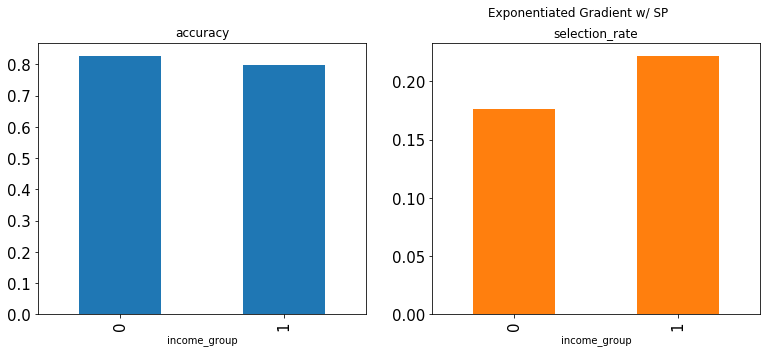

In [97]:
'''
TEST SET
'''
metric_frame_eg = MetricFrame(metric = {"accuracy": skm.accuracy_score,
                                        "selection_rate": selection_rate},
                                   sensitive_features = A_test,
                                   y_true = y_test,
                                   y_pred = y_pred_eg)

print(metric_frame_eg.overall)
print("-"*30)
print(metric_frame_eg.by_group)
print("-"*30)
print("accuracy:", "{:.5f}".format(metric_frame_eg.overall["accuracy"]))
print("accuracy diff:", "{:.5f}".format(metric_frame_eg.difference()["accuracy"]))
print("selection_rate:", "{:.5f}".format(metric_frame_eg.overall["selection_rate"]))
print("selection_rate diff:", "{:.5f}".format(metric_frame_eg.difference()["selection_rate"]))

print("-"*30)

model_summary.loc["exp_grad", "accuracy"] = metric_frame_eg.overall["accuracy"]
model_summary.loc["exp_grad", "accuracy_diff"] = metric_frame_eg.difference()["accuracy"]
model_summary.loc["exp_grad", "selection_rate"] = metric_frame_eg.overall["selection_rate"]
model_summary.loc["exp_grad", "selection_rate_diff"] = metric_frame_eg.difference()["selection_rate"]


metric_frame_eg.by_group.plot.bar(
        subplots=True, layout=[1, 3], legend=False, figsize=[20, 5],
        title='Exponentiated Gradient w/ SP', fontsize = 15)
# plt.savefig(os.path.join(save_dir_models, CITY +"exp_grad_metric"))

### 3) Grid Search (constraint: BGL)

In [98]:
kfold = KFold(2, shuffle = True, random_state = 42)

# randomly get train valid set
for train, valid in kfold.split(X_train):
    # print("CV")
    X_train_gs = X_train.loc[train]
    y_train_gs = y_train.loc[train]
    A_train_gs = A_train.loc[train]

    X_valid = X_train.loc[valid]
    y_valid = y_train.loc[valid]
    A_valid = A_train.loc[valid]

In [100]:
# get all predictors according to best grid size
acc_all = []
selection_rate_diff_all = []
mitigator = GridSearch(estimator = rf_best,
                       constraints = DemographicParity(difference_bound = best_diff),
                       grid_size = 100)

mitigator.fit(X_train_gs, y_train_gs, sensitive_features = A_train_gs)
predictors = mitigator.predictors_

In [101]:
# get dominant model on valid set
for i in range(len(predictors)):
    metric_frame = MetricFrame(metric = {"accuracy": skm.accuracy_score,
                                        "selection_rate": selection_rate},
                               sensitive_features = A_valid,
                               y_true = y_valid, 
                               y_pred = predictors[i].predict(X_valid))
    
    acc_all.append(metric_frame.overall["accuracy"])
    selection_rate_diff_all.append(metric_frame.difference()["selection_rate"])
    
# get dominant models
all_results = pd.DataFrame({"predictors:": predictors, "acc": acc_all, "diff": selection_rate_diff_all})

gs_dominant_final = []
for row in all_results.itertuples():
    '''
    want the models that have the high R^2 with low difference
    thus, we select model M if all of other models with higher R^2 than M also have higher difference than M.
    # i.e. M has the lowest difference among all of the models that have higher R^2 than it.
    '''
    difference = all_results["diff"][all_results["acc"] >= row.acc]
    if row.diff <= difference.min():
        gs_dominant_final.append(row[1])

In [102]:
# loop all of the dominant models on test set
acc_dominated = []
# acc_diff_dominated = []
selection_rate_diff_dominated = []

for i in range(len(gs_dominant_final)):
    metric_frame_dominant = MetricFrame(metric={"accuracy": skm.accuracy_score,
                                                "selection_rate": selection_rate},
                               sensitive_features = A_test,
                               y_true = y_test,
                               y_pred = gs_dominant_final[i].predict(X_test))

    
    acc_dominated.append(metric_frame_dominant.overall["accuracy"])
    selection_rate_diff_dominated.append(metric_frame_dominant.difference()["selection_rate"])

In [103]:
# calculate gs model with lowest MAE diff
gs_least_mae_idx = np.argmin(np.array(selection_rate_diff_dominated))
gs_least_mae_idx

1

In [105]:
# # save model
# Pkl_Filename = "grid_search_SP.pkl"
# with open(os.path.join(save_dir_models, CITY + Pkl_Filename), 'wb') as file:  
#     pickle.dump(gs_dominant_final[gs_least_mae_idx], file)

In [106]:
gs_dominant_model = pickle.load(open(os.path.join(save_dir_models, CITY + "grid_search_SP.pkl"), 'rb'))

accuracy         0.8621
selection_rate   0.2414
dtype: object
------------------------------
             accuracy selection_rate
income_group                        
0              0.8284         0.1667
1              0.9097         0.3472
accuracy: 0.86207
accuracy diff: 0.08129
selection_rate: 0.24138
selection_rate diff: 0.18056
------------------------------


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f793a958610>,
      dtype=object)

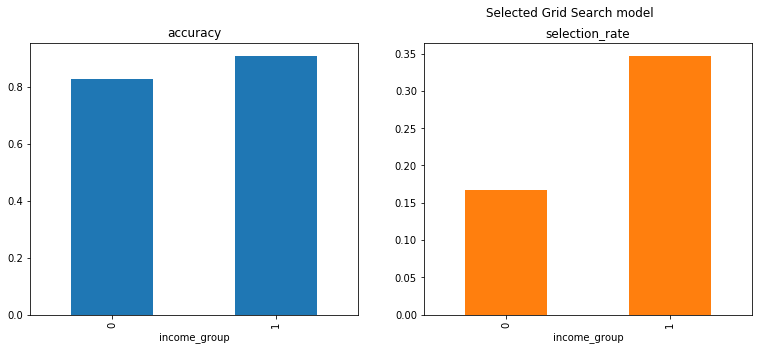

In [107]:
'''
TEST SET
'''
# gs_dominant_model = gs_dominant_final[gs_least_mae_idx]
y_pred_gs = gs_dominant_model.predict(X_test)
metric_frame_gs = MetricFrame(metric = {"accuracy": skm.accuracy_score,
                                        "selection_rate": selection_rate},
                               sensitive_features = A_test,
                               y_true = y_test,
                               y_pred = y_pred_gs)

gs_eo_diff = equalized_odds_difference(y_test, y_pred_gs, sensitive_features = A_test)

print(metric_frame_gs.overall)
print("-"*30)
print(metric_frame_gs.by_group)

print("accuracy:", "{:.5f}".format(metric_frame_gs.overall["accuracy"]))
print("accuracy diff:", "{:.5f}".format(metric_frame_gs.difference()["accuracy"]))
print("selection_rate:", "{:.5f}".format(metric_frame_gs.overall["selection_rate"]))
print("selection_rate diff:", "{:.5f}".format(metric_frame_gs.difference()["selection_rate"]))

print("-"*30)

model_summary.loc["grid_search", "accuracy"] = metric_frame_gs.overall["accuracy"]
model_summary.loc["grid_search", "accuracy_diff"] = metric_frame_gs.difference()["accuracy"]
model_summary.loc["grid_search", "selection_rate"] = metric_frame_gs.overall["selection_rate"]
model_summary.loc["grid_search", "selection_rate_diff"] = metric_frame_gs.difference()["selection_rate"]

metric_frame_gs.by_group.plot.bar(
        subplots=True, layout=[1, 3], legend=False, figsize=[20, 5],
        title='Selected Grid Search model')

# plt.savefig(os.path.join(save_dir_models, CITY+"grid_search_metric"))

In [108]:
metric_frame_rf_gs

Text(0.5, 1.0, 'Scatter plot of 3 models (Constraint: Equalized Odds)')

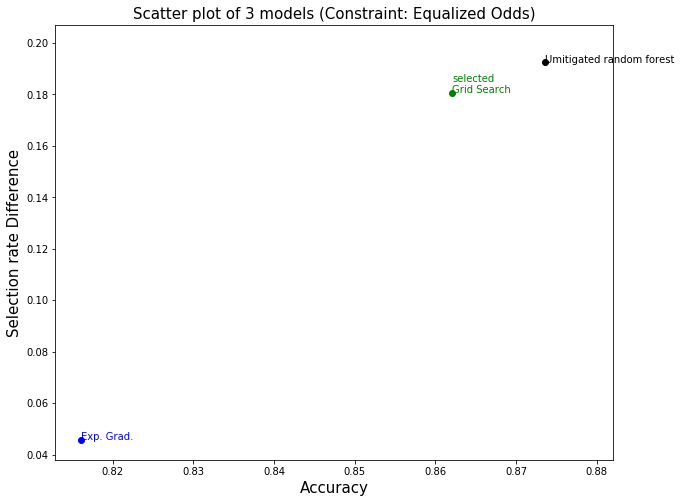

In [109]:
# plot only the dominated models

plt.figure(figsize = (10, 8))
# plt.scatter(r2_dominated, mae_diff_dominated)

# Label previous fair-unaware model
plt.scatter(metric_frame_rf_gs.overall["accuracy"], metric_frame_rf_gs.difference()["selection_rate"], color = 'black')
plt.text(metric_frame_rf_gs.overall["accuracy"], metric_frame_rf_gs.difference()["selection_rate"], "Umitigated random forest", color = 'black')

# Selected grid search model
plt.scatter(metric_frame_eg.overall["accuracy"], metric_frame_eg.difference()["selection_rate"], color = 'blue')
plt.text(metric_frame_eg.overall["accuracy"], metric_frame_eg.difference()["selection_rate"], "Exp. Grad.", color = 'blue')

# expmonentiated gradient
plt.scatter(metric_frame_gs.overall['accuracy'], metric_frame_gs.difference()["selection_rate"], color = 'green')
plt.text(metric_frame_gs.overall['accuracy'], metric_frame_gs.difference()["selection_rate"], "selected\nGrid Search", color = 'green')

plt.xlabel("Accuracy", fontsize = 15)
plt.ylabel("Selection rate Difference", fontsize = 15)
plt.title("Scatter plot of 3 models (Constraint: Equalized Odds)", fontsize = 15)
# plt.xlim((0.806, 0.811))
# plt.savefig(os.path.join(save_dir_models, CITY +"models_scatter_res"))

In [125]:
# model_summary.to_csv(os.path.join(save_dir_models, CITY +"model_summary_SP.csv"))